In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
host,=!uname -n
print("Running on " + host)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
print("Tensorflow version is: %s" % tf.__version__)
print("GPU available for TF:  %s" % tf.test.is_gpu_available())

Running on scylla
2 Physical GPUs, 2 Logical GPUs
Tensorflow version is: 2.0.0-beta0
GPU available for TF:  True


### Learning from dice sequences
This is a toy problem. Any sequence of 5 throws is rewarded with a particular value based on some prior *truth*. Ten different independent dice are being rewarded at the same time. 

Think of this as 5 consecutive days of trading in 10 different stocks. For each stock, there's one day where buying it will give an immediate reward. That reward is different for every stock and every day, based on the *mask* matrix below.

We hope that the network learns when what stock to trade on what day.

In [4]:
BATCH_SIZE = 3
N_STEPS = 5
N_FEATURES = 10

N_STEPS consecutive samples with N_FEATURES dice. Each sequence of N_STEPS gets a score. E.g. the first die gets a tenth of what the first result was. So, each die (feature) is independent of the others.

In [5]:
x = np.floor(np.random.random([BATCH_SIZE, N_STEPS, N_FEATURES]) * 7).astype(np.float32)
x.shape

(3, 5, 10)

In [6]:
mask = np.zeros((5,10), dtype=np.float32)

for k in range(5):
    mask[k][k]=(k+1)/10.
    mask[k][k+5]=.6-(k+1)/10.

mask

array([[0.1, 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0.3, 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.1]], dtype=float32)

In [7]:
def truth(x):
    logits = np.round(np.sum(x * mask, axis=0), 3)
    e = np.exp(logits)
    return e / np.sum(e)

In [8]:
t = truth(x[0]);t

array([0.066071  , 0.10893267, 0.05409437, 0.04007409, 0.04007409,
       0.2961097 , 0.13305067, 0.09856635, 0.10893267, 0.05409437],
      dtype=float32)

In [9]:
np.sum(t)

1.0

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import activations

## Heuristic
Try to just mimic the truth function, let it find out the mask values

In [11]:
class Heuristic_TradeModel(tf.keras.Model):
    def __init__(self, units):
        super(Heuristic_TradeModel, self).__init__()
        self.selector = layers.Dense(
            10, activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l=0.1))
        self.denses = [layers.Dense(u, activation='relu') for u in units]
        self.logits = layers.Dense(10, activation = None)
        
    def call(self, inputs):
        out = tf.cast(inputs / 100, dtype=tf.float32)
        out = tf.reshape(out, shape=[-1, 50])
        out = self.selector(out)
        for layer in self.denses:
            out = layer(out) 
        out = self.logits(out)
        return out
    
    def portfolio(self, inputs):
        return activations.softmax(self.call(inputs))

model = Heuristic_TradeModel([64])
x = np.floor(np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]) * 7).astype(np.float32)

_ = model(x)
model.summary()

Model: "heuristic__trade_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  510       
_________________________________________________________________
dense_1 (Dense)              multiple                  704       
_________________________________________________________________
dense_2 (Dense)              multiple                  650       
Total params: 1,864
Trainable params: 1,864
Non-trainable params: 0
_________________________________________________________________


## LSTM and Dense Model 
...just don't work!!

In [226]:
class Dense_TradeModel(tf.keras.Model):
    def __init__(self, units):
        super(Dense_TradeModel, self).__init__()
        self.selector = layers.Dense(
            10, activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l1(l=0.1))
        self.denses = [layers.Dense(u, activation='relu') for u in units]
        self.logits = layers.Dense(10, activation = None)
        
    def call(self, inputs):
        out = tf.cast(inputs, dtype=tf.float32)
        out = tf.reshape(out, shape=[-1, 50])
        out = self.selector(out)
        for layer in self.denses:
            out = layer(out) 
        out = self.logits(out)
        return out
    
    def portfolio(self, inputs):
        return activations.softmax(self.call(inputs))

model = Dense_TradeModel([64, 128, 64])
x = np.floor(np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]) * 7).astype(np.float32)

_ = model(x)
model.summary()

Model: "dense__trade_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             multiple                  510       
_________________________________________________________________
dense_18 (Dense)             multiple                  704       
_________________________________________________________________
dense_19 (Dense)             multiple                  8320      
_________________________________________________________________
dense_20 (Dense)             multiple                  8256      
_________________________________________________________________
dense_21 (Dense)             multiple                  650       
Total params: 18,440
Trainable params: 18,440
Non-trainable params: 0
_________________________________________________________________


In [424]:
class LSTM_TradeModel(tf.keras.Model):
    def __init__(self, n_neurons):
        super(LSTM_TradeModel, self).__init__()
        self.lstm = layers.LSTM(
            n_neurons, 
            input_shape=[None, 5, 10],
            return_sequences=False)
        self.logits = layers.Dense(10, activation = None)
        
    def call(self, inputs):
        out = tf.cast(inputs, dtype=tf.float32)
        out = self.lstm(out) 
        out = self.logits(out)
        return out
    
    def portfolio(self, inputs):
        return activations.softmax(self.call(inputs))

model = LSTM_TradeModel(128)
x = np.floor(np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]) * 7).astype(np.float32)

_ = model(x)
model.summary()

Model: "lstm__trade_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                multiple                  71168     
_________________________________________________________________
dense_25 (Dense)             multiple                  1290      
Total params: 72,458
Trainable params: 72,458
Non-trainable params: 0
_________________________________________________________________


In [425]:
model.portfolio(x).numpy()

array([[0.16817154, 0.08938   , 0.08206645, 0.07084215, 0.06438243,
        0.12043565, 0.05463945, 0.12428629, 0.12845062, 0.09734542],
       [0.17806405, 0.07707066, 0.10308179, 0.07331615, 0.04551242,
        0.14613456, 0.05539326, 0.11012829, 0.10870326, 0.10259555],
       [0.16724215, 0.08722932, 0.08776763, 0.07543791, 0.0431552 ,
        0.12041067, 0.04920189, 0.17400296, 0.10022201, 0.09533028]],
      dtype=float32)

In [426]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss, optimizer=optimizer)

In [427]:
def new_data_set(n_steps, n_features, total_size,
                 batch_size, buffer_size=1000):
    def _generator():
        for _ in range(total_size):
            x = np.floor( np.random.random(
                    [n_steps, n_features]) * 7).astype(np.float32)
            y = truth(x)
            yield x/20,y

    inputs = tf.data.Dataset.from_generator(
        _generator, output_types = (tf.float32, tf.float32))

    inputs = inputs.shuffle(buffer_size).batch(batch_size)

    return inputs

In [428]:
dataset = new_data_set(5, 10, 1000, 1)
iterator = iter(dataset)

In [429]:
next(iterator)

(<tf.Tensor: id=35252, shape=(1, 5, 10), dtype=float32, numpy=
 array([[[0.05, 0.3 , 0.2 , 0.2 , 0.15, 0.15, 0.05, 0.1 , 0.  , 0.2 ],
         [0.  , 0.1 , 0.05, 0.  , 0.25, 0.2 , 0.05, 0.05, 0.3 , 0.1 ],
         [0.  , 0.3 , 0.15, 0.1 , 0.15, 0.25, 0.2 , 0.1 , 0.  , 0.3 ],
         [0.3 , 0.1 , 0.  , 0.1 , 0.2 , 0.25, 0.3 , 0.2 , 0.  , 0.  ],
         [0.15, 0.2 , 0.  , 0.25, 0.  , 0.2 , 0.3 , 0.1 , 0.15, 0.2 ]]],
       dtype=float32)>,
 <tf.Tensor: id=35253, shape=(1, 10), dtype=float32, numpy=
 array([[0.05951507, 0.08033694, 0.13245323, 0.11984863, 0.05385146,
         0.24134551, 0.08033694, 0.09812377, 0.05385146, 0.08033694]],
       dtype=float32)>)

In [499]:
dataset = new_data_set(5, 10, 100000, 20000)
model.fit(dataset, epochs=20)

Epoch 1/20
5/5 [==============================] - 13s 3s/step - loss: 2.0045
Epoch 2/20
5/5 [==============================] - 13s 3s/step - loss: 2.0091
Epoch 3/20
5/5 [==============================] - 13s 3s/step - loss: 2.0048
Epoch 4/20
5/5 [==============================] - 12s 2s/step - loss: 2.0032
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 2.0026
Epoch 6/20
5/5 [==============================] - 12s 2s/step - loss: 2.0006
Epoch 7/20
5/5 [==============================] - 12s 2s/step - loss: 1.9995
Epoch 8/20
5/5 [==============================] - 12s 2s/step - loss: 1.9999
Epoch 9/20
5/5 [==============================] - 13s 3s/step - loss: 1.9985
Epoch 10/20
5/5 [==============================] - 13s 3s/step - loss: 1.9974
Epoch 11/20
5/5 [==============================] - 13s 3s/step - loss: 1.9976
Epoch 12/20
5/5 [==============================] - 12s 2s/step - loss: 1.9972
Epoch 13/20
5/5 [==============================] - 12s 2s/step - loss: 1.

In [500]:
model.evaluate(new_data_set(5, 10, 100, 100))

      1/Unknown - 0s 22ms/step - loss: 2.0112

2.0112242698669434

In [501]:
dataset = new_data_set(5, 10, 1000, 1)
iterator = iter(dataset)

In [502]:
x, y = next(iterator)
print(model.portfolio(x).numpy(), y)

[[0.02355975 0.03918843 0.07514225 0.13082215 0.05361094 0.4620374
  0.09835409 0.05506898 0.03777958 0.02443642]] tf.Tensor(
[[0.02507842 0.05581304 0.09202015 0.15171559 0.05581304 0.41240573
  0.101698   0.0374126  0.0374126  0.03063085]], shape=(1, 10), dtype=float32)


In [503]:
import seaborn as sns

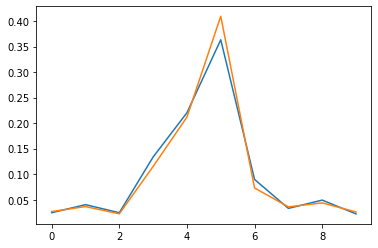

In [557]:
x, y = next(iterator)
sns.lineplot(np.arange(10), y[0].numpy())
sns.lineplot(np.arange(10), model.portfolio(x)[0].numpy())